# Load packages

In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
import matplotlib.pyplot as plt
import scanpy as sc
import anndata2ri
import logging
from scipy.sparse import csr_matrix, issparse
import numpy as np
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
#import bbknn
import pandas as pd
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import scipy as sp
import scvi
import torch
scvi.settings.seed = 0

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
#sc.logging.print_versions()


os.chdir('/root/host_home')
sc.logging.print_versions()

Seed set to 0


-----
anndata     0.10.7
scanpy      1.10.1
-----
PIL                         10.1.0
absl                        NA
anndata2ri                  1.3.1
anyio                       NA
arrow                       1.3.0
asttokens                   NA
astunparse                  1.6.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.14.0
backcall                    0.2.0
cairo                       1.26.0
certifi                     2023.11.17
cffi                        1.16.0
chardet                     5.2.0
charset_normalizer          3.3.2
chex                        0.1.86
cloudpickle                 3.0.0
comm                        0.2.1
contextlib2                 NA
cupy                        12.3.0
cupy_backends               NA
cupyx                       NA
cycler                      0.12.1
cython_runtime              NA
dask                        2023.11.0
dateutil                    2.8.2
debugpy                     1.8.0
d

# Filenames

In [2]:
#Filename scanpy AnnData input for hp NPC after batch correction
adata_input = 'hp_NPCs/processed_data/hp_NPC_cell_cycle_cuda_soup.h5ad'


#Filename scanpy AnnData output for NPC preprocessing
adata_output = 'hp_NPCs/processed_data/hp_NPC_clustered_scvi_cuda_soup.h5ad'

In [3]:
lane_key = "lane"
donor_key = "Donor"
dataset_key = "cultivation_period"
label_key = "condition"

# Read in data

In [4]:
adata = sc.read(adata_input)


In [4]:
#adata = sc.read(adata_output)

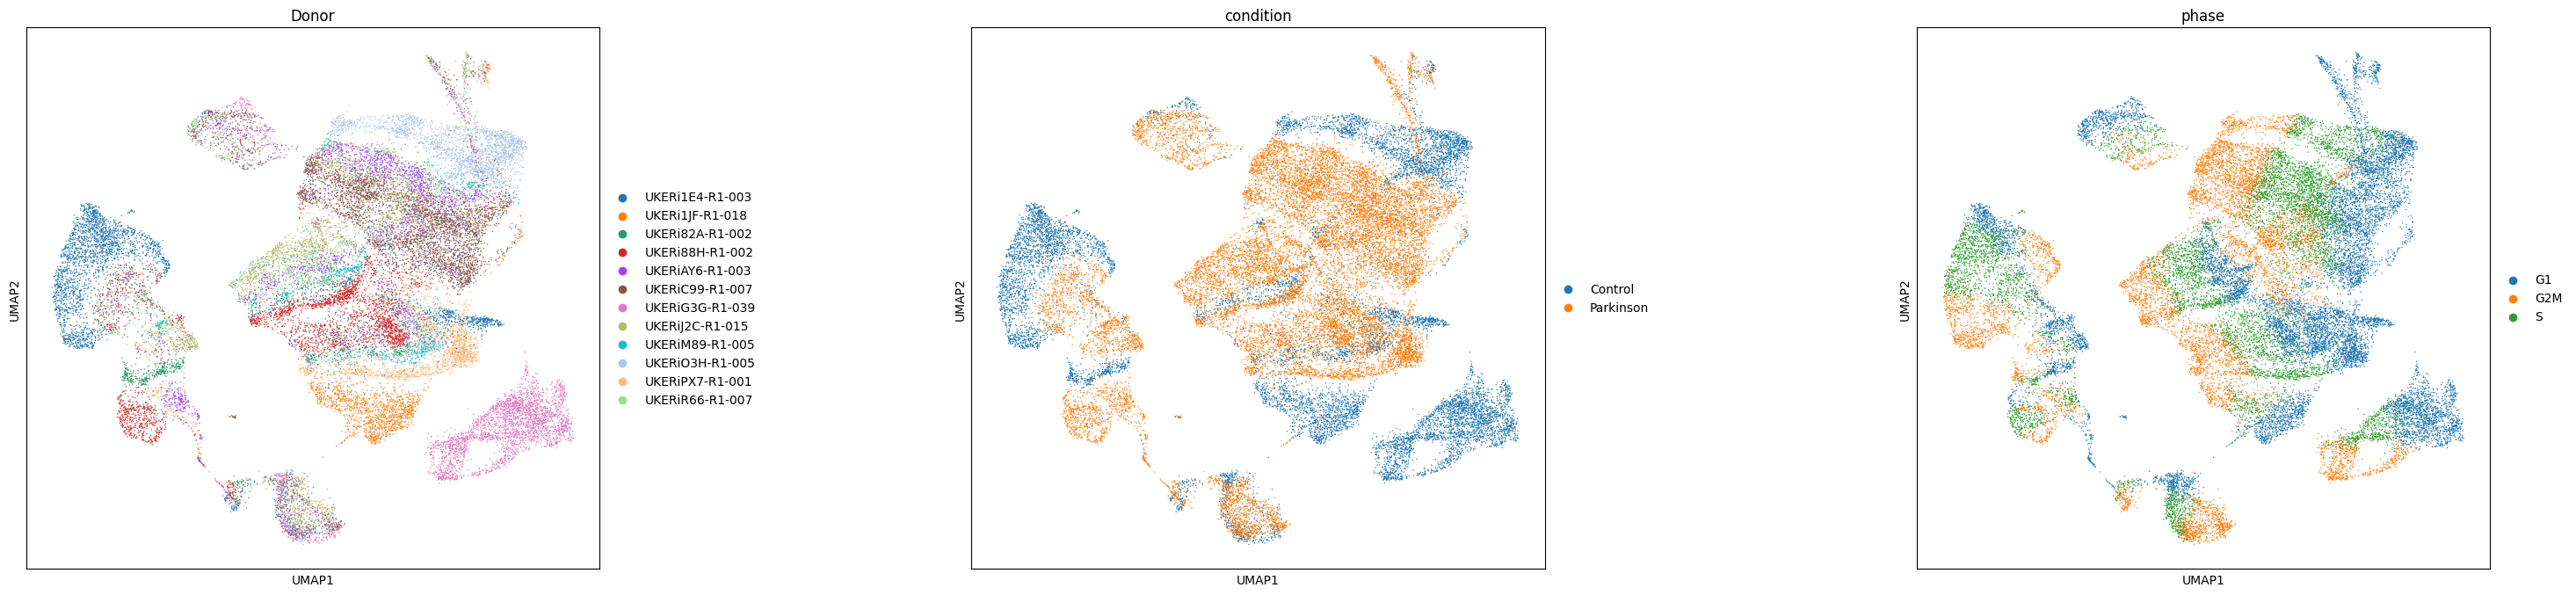

In [6]:
sc.pl.umap(adata, color=[donor_key, label_key, 'phase'], wspace = 0.5)

# Integration

In [7]:
adata.var['highly_variable'] = adata.var['highly_variable_genes_batch_aware']

In [8]:
#Data preparation
scvi.model.SCVI.setup_anndata(adata, layer="soupX_counts", batch_key=donor_key)
adata

AnnData object with n_obs × n_vars = 30557 × 16774
    obs: 'lane', 'Demux_state', 'Donor', 'cell_types', 'condition', 'age', 'years_of_illness', 'deltaHY', 'deltaUPDRS', 'deltaADL', 'deltaDOPA', 'gender', 'cultivation_period', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'batch', 'size_factors', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_genes', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable

In [9]:
#Building the model
model_scvi = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood='zinb')
model_scvi

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [10]:
#Print description of the model
model_scvi.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.2.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'soupX_counts',
│   'batch_key': 'Donor',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  12   │
│         n_cells          │ 30557 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 16774 │
└──────────────────────────┴───────┘

                 Data Registry                 
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃     scvi-tools Location      ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │ adata.layers['soupX_counts'] │
│    batch     │   adata.obs['_scvi_batch']   │
│    labels    │  adata.obs['_scvi_labels']   │
└──────────────┴──────────────────────────────┘

                     batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃   Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Donor'] │ UKERi1E4-R1-003 │          0          │
│                    │ UKERi1JF-R1-018 │          1          │
│                    │ UKERi82A-R1-002 │          2          │
│                    │ UKERi88H-R1-002 │          3          │
│                    │ UKERiAY6-R1-003 │          4          │
│                    │ UKERiC99-R1-007 │          5          │
│                    │ UKERiG3G-R1-039 │          6          │
│                    │ UKERiJ2C-R1-015 │          7          │
│                    │ UKERiM89-R1-005 │          8          │
│                    │ UKERiO3H-R1-005 │          9          │
│                    │ UKERiPX7-R1-001 │         10          │
│                    │ UKERiR66-R1-007 │         11          │
└────────────────────┴─────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [11]:
torch.set_float32_matmul_precision('medium')
scvi.settings.dl_num_workers = 15

In [12]:
model_scvi.train(check_val_every_n_epoch=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 262/262: 100%|█████████| 262/262 [22:46<00:00,  5.23s/it, v_num=1, train_loss_step=9.69e+3, train_loss_epoch=1e+4]

`Trainer.fit` stopped: `max_epochs=262` reached.


Epoch 262/262: 100%|█████████| 262/262 [22:46<00:00,  5.22s/it, v_num=1, train_loss_step=9.69e+3, train_loss_epoch=1e+4]


In [13]:
#Extract embeddings
adata.obsm["X_scVI_CC"] = model_scvi.get_latent_representation()

In [14]:
#Calculate bath-corrected UMAP
sc.pp.neighbors(adata, use_rep="X_scVI_CC")
sc.tl.umap(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:33)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


In [15]:
adata.uns['neighbors_CC'] = adata.uns['neighbors']
adata.obsp['distances_CC'] = adata.obsp['distances']
adata.obsp['connectivities_CC'] = adata.obsp['connectivities']
adata.obsm['X_umap_CC'] = adata.obsm['X_umap']

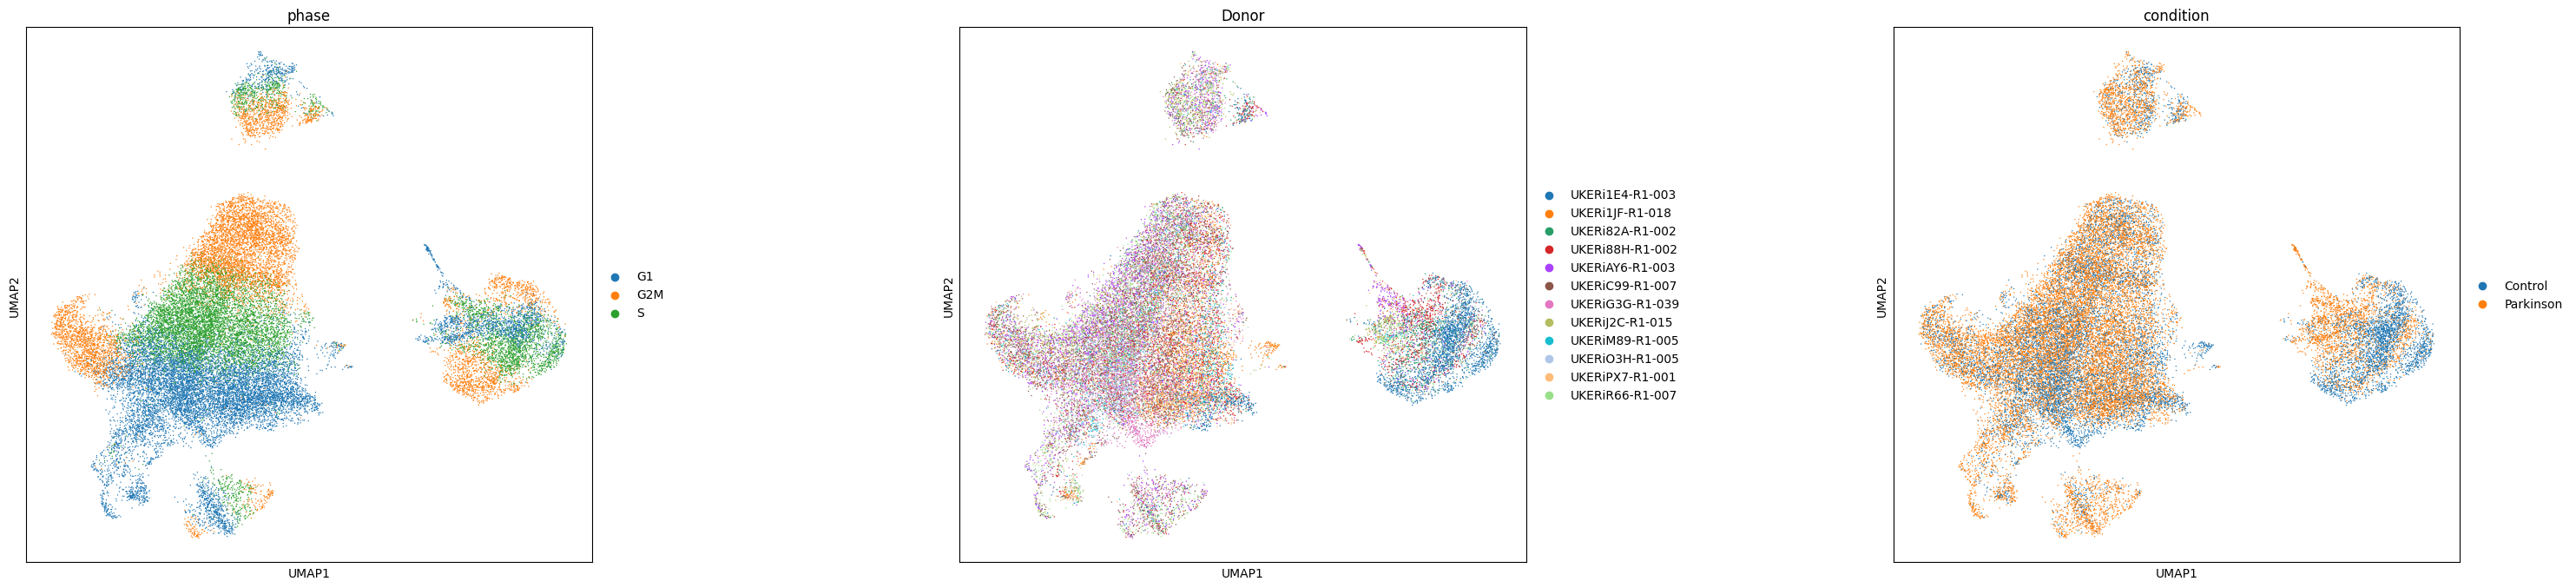

In [16]:
sc.pl.umap(adata, color=['phase', donor_key, label_key], wspace = 0.5)

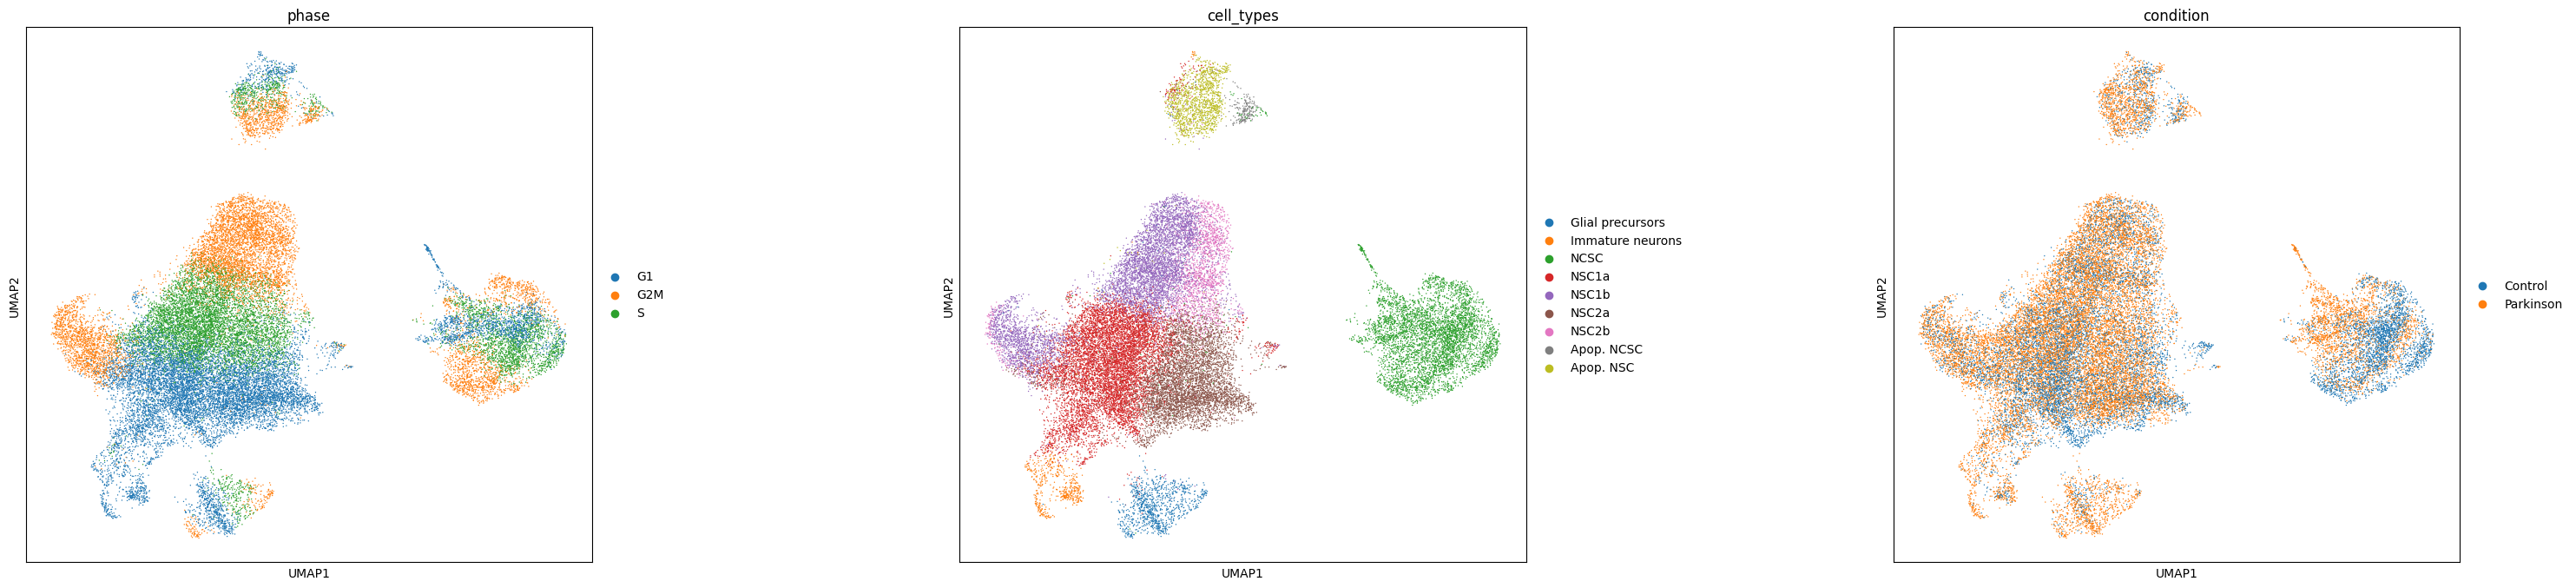

In [17]:
sc.pl.umap(adata, color=['phase', 'cell_types' , label_key], ncols=3, wspace = 0.5)

# Regress out cell cycle

In [18]:
adata

AnnData object with n_obs × n_vars = 30557 × 16774
    obs: 'lane', 'Demux_state', 'Donor', 'cell_types', 'condition', 'age', 'years_of_illness', 'deltaHY', 'deltaUPDRS', 'deltaADL', 'deltaDOPA', 'gender', 'cultivation_period', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'batch', 'size_factors', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_genes', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable

In [19]:
#Data preparation
scvi.model.SCVI.setup_anndata(adata, layer="soupX_counts", batch_key=donor_key, continuous_covariate_keys = ['S_score', 'G2M_score'])
adata

AnnData object with n_obs × n_vars = 30557 × 16774
    obs: 'lane', 'Demux_state', 'Donor', 'cell_types', 'condition', 'age', 'years_of_illness', 'deltaHY', 'deltaUPDRS', 'deltaADL', 'deltaDOPA', 'gender', 'cultivation_period', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'batch', 'size_factors', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_genes', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable

In [20]:
#Building the model
model_scvi = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood='zinb')
model_scvi

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [21]:
#Print description of the model
model_scvi.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.2.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'soupX_counts',
│   'batch_key': 'Donor',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': ['S_score', 'G2M_score']
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  12   │
│         n_cells          │ 30557 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   2   │
│         n_labels         │   1   │
│          n_vars          │ 16774 │
└──────────────────────────┴───────┘

                            Data Registry                            
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Registry Key      ┃            scvi-tools Location            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X           │       adata.layers['soupX_counts']        │
│         batch         │         adata.obs['_scvi_batch']          │
│ extra_continuous_covs │ adata.obsm['_scvi_extra_continuous_covs'] │
│        labels         │         adata.obs['_scvi_labels']         │
└───────────────────────┴───────────────────────────────────────────┘

                     batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃   Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Donor'] │ UKERi1E4-R1-003 │          0          │
│                    │ UKERi1JF-R1-018 │          1          │
│                    │ UKERi82A-R1-002 │          2          │
│                    │ UKERi88H-R1-002 │          3          │
│                    │ UKERiAY6-R1-003 │          4          │
│                    │ UKERiC99-R1-007 │          5          │
│                    │ UKERiG3G-R1-039 │          6          │
│                    │ UKERiJ2C-R1-015 │          7          │
│                    │ UKERiM89-R1-005 │          8          │
│                    │ UKERiO3H-R1-005 │          9          │
│                    │ UKERiPX7-R1-001 │         10          │
│                    │ UKERiR66-R1-007 │         11          │
└────────────────────┴─────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

  extra_continuous_covs   
      State Registry      
┏━━━━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━┩
│  adata.obs['S_score']  │
│ adata.obs['G2M_score'] │
└────────────────────────┘

In [22]:
torch.set_float32_matmul_precision('medium')
scvi.settings.dl_num_workers = 15

In [23]:
model_scvi.train(check_val_every_n_epoch=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 262/262: 100%|█████████| 262/262 [25:33<00:00,  5.90s/it, v_num=1, train_loss_step=9.95e+3, train_loss_epoch=1e+4]

`Trainer.fit` stopped: `max_epochs=262` reached.


Epoch 262/262: 100%|█████████| 262/262 [25:33<00:00,  5.85s/it, v_num=1, train_loss_step=9.95e+3, train_loss_epoch=1e+4]


In [24]:
#Extract embeddings
adata.obsm["X_scVI_noCC"] = model_scvi.get_latent_representation()

In [25]:
#Calculate bath-corrected UMAP
sc.pp.neighbors(adata, use_rep="X_scVI_noCC")
sc.tl.umap(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


In [26]:
adata.uns['neighbors_noCC'] = adata.uns['neighbors']
adata.obsp['distances_noCC'] = adata.obsp['distances']
adata.obsp['connectivities_noCC'] = adata.obsp['connectivities']
adata.obsm['X_umap_noCC'] = adata.obsm['X_umap']

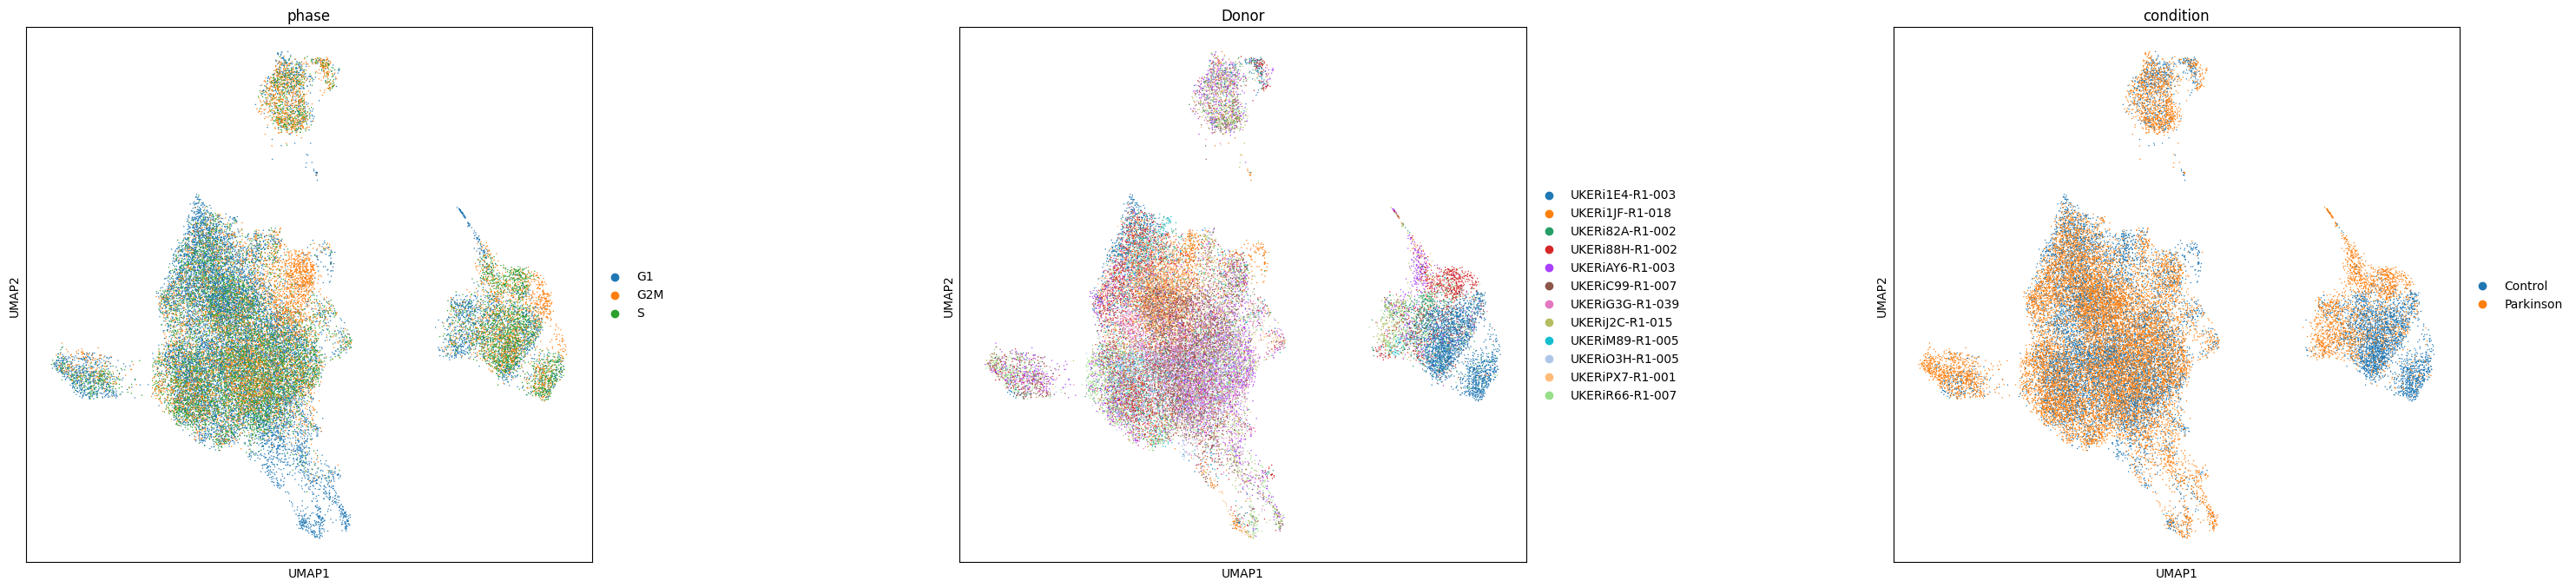

In [27]:
sc.pl.umap(adata, color=['phase', 'Donor', label_key], ncols=3, wspace = 0.5)

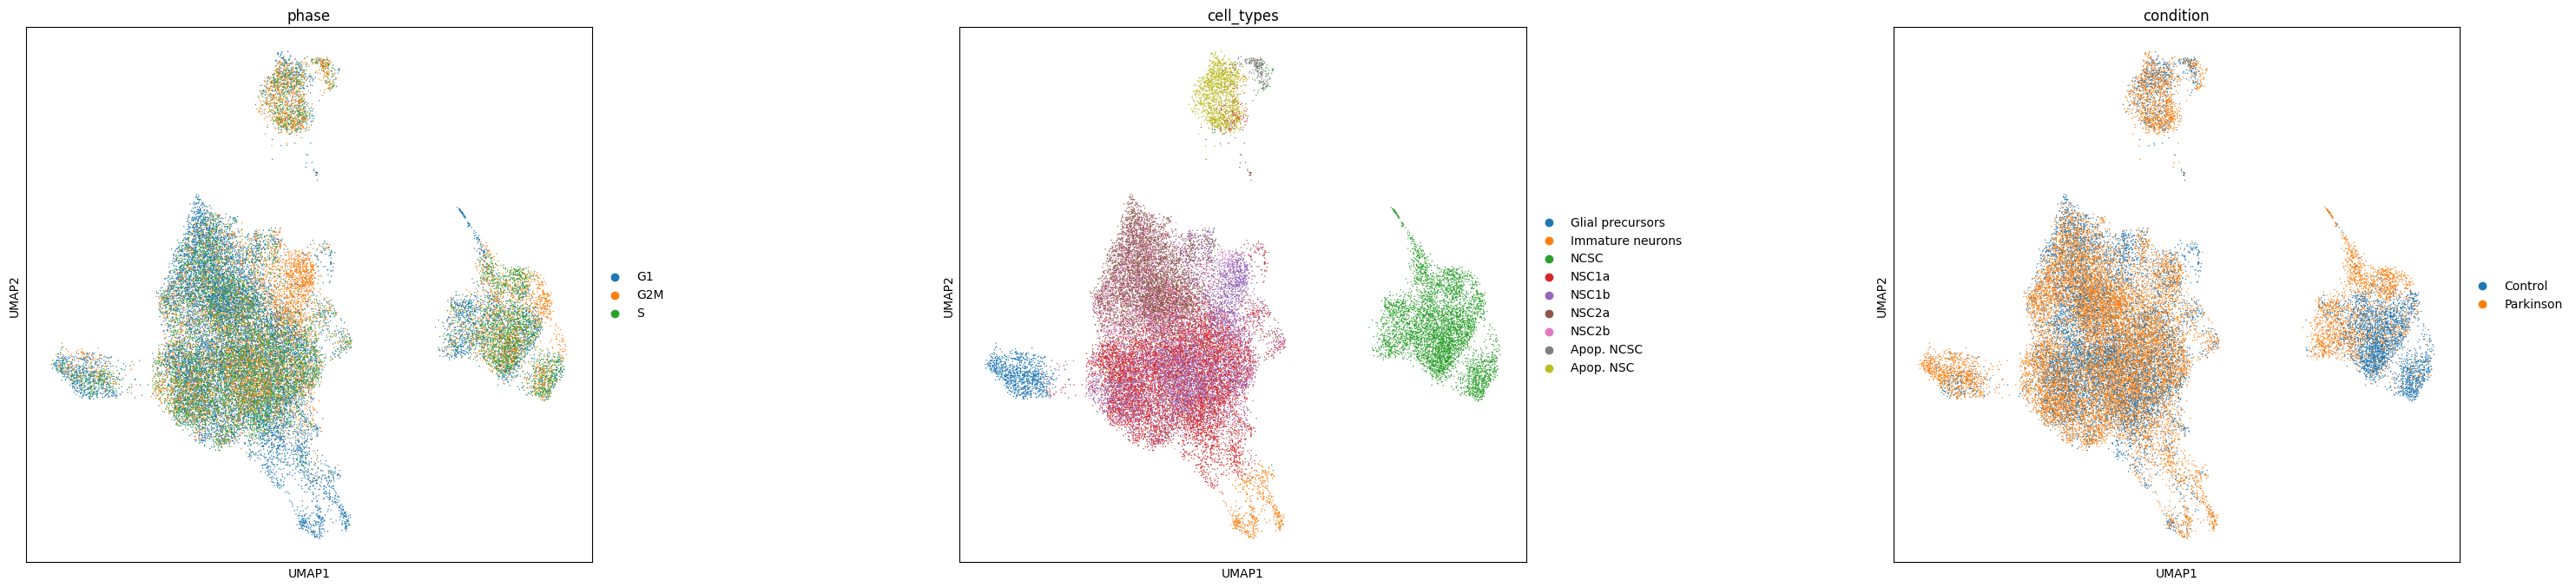

In [28]:
sc.pl.umap(adata, color=['phase', 'cell_types' , label_key], ncols=3, wspace = 0.5)

## Cell death analysis

In [29]:
cell_death_markers = dict()
cell_death_markers['Ferroptosis_pos'] = ['VDAC2', 'VDAC3', 'NRAS', 'KRAS', 'NOX1', 'NOX4', 'NOX5', 'TFRC', 'TP53', 'CARS', 'ACSL4']
cell_death_markers['Ferroptosis_neg'] = ['GPX4', 'SLC7A11', 'HSPB1', 'NFE2L2']
cell_death_markers['Apoptosis_pos'] = ['TP53', 'BAX', 'BAK1'] #other pro apoptotic BCL2 family members
cell_death_markers['Apoptosis_neg'] = ['BCL2', 'BCL2L1', 'MCL1'] #other anti apoptotic BCL2 family members
cell_death_markers['Necroptosis_pos'] = ['RIPK1', 'RIPK3', 'MLKL']
cell_death_markers['Autophagy_pos'] = ['ATG5', 'ATG7', 'BECN1'] #other ATG family proteins
cell_death_markers['Pathanatos_pos'] = ['AIFM1', 'PARP1']

computing score 'Ferroptosis_pos_corr'
    finished: added
    'Ferroptosis_pos_corr', score of gene set (adata.obs).
    399 total control genes are used. (0:00:01)


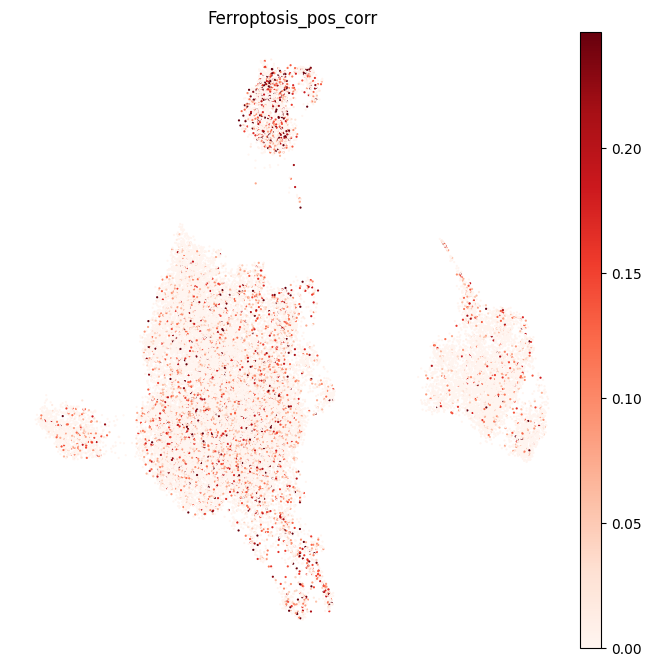

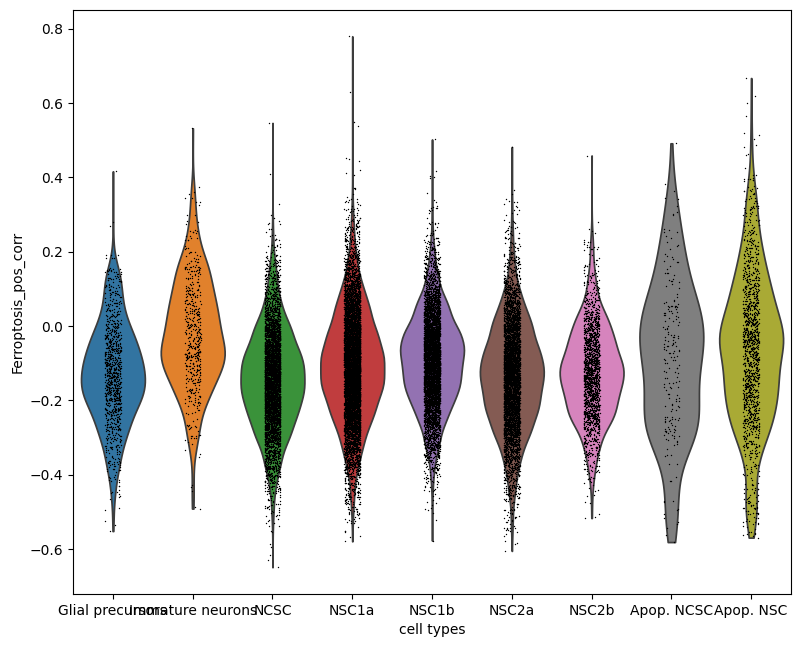

computing score 'Ferroptosis_neg_corr'
    finished: added
    'Ferroptosis_neg_corr', score of gene set (adata.obs).
    150 total control genes are used. (0:00:01)


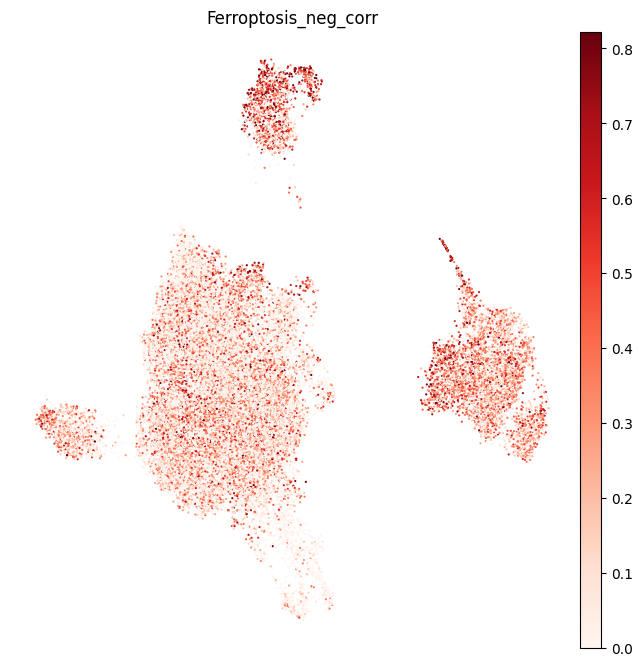

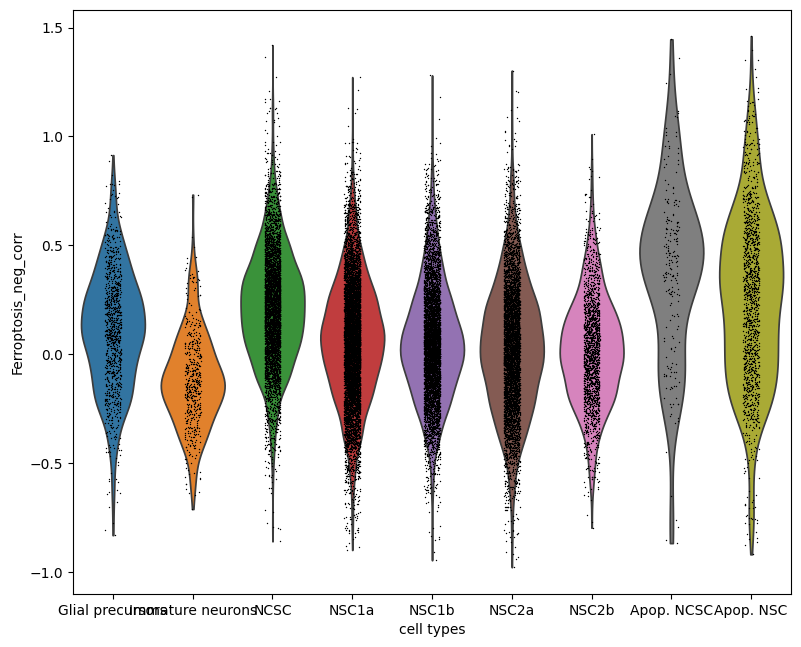

computing score 'Apoptosis_pos_corr'
    finished: added
    'Apoptosis_pos_corr', score of gene set (adata.obs).
    150 total control genes are used. (0:00:01)


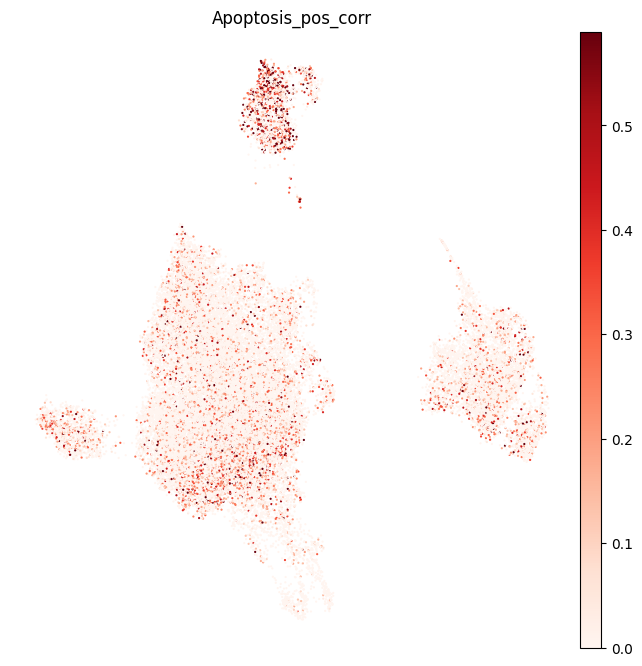

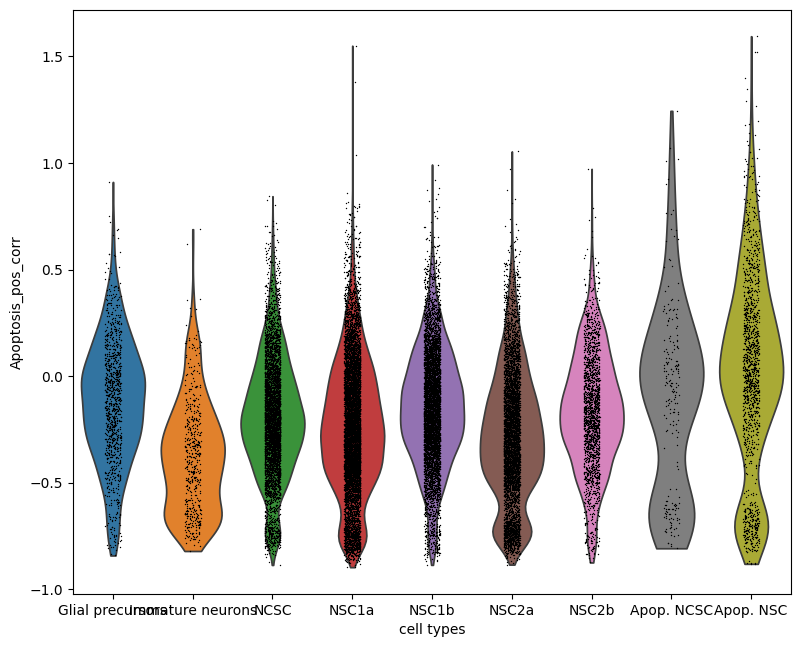

computing score 'Apoptosis_neg_corr'
    finished: added
    'Apoptosis_neg_corr', score of gene set (adata.obs).
    150 total control genes are used. (0:00:01)


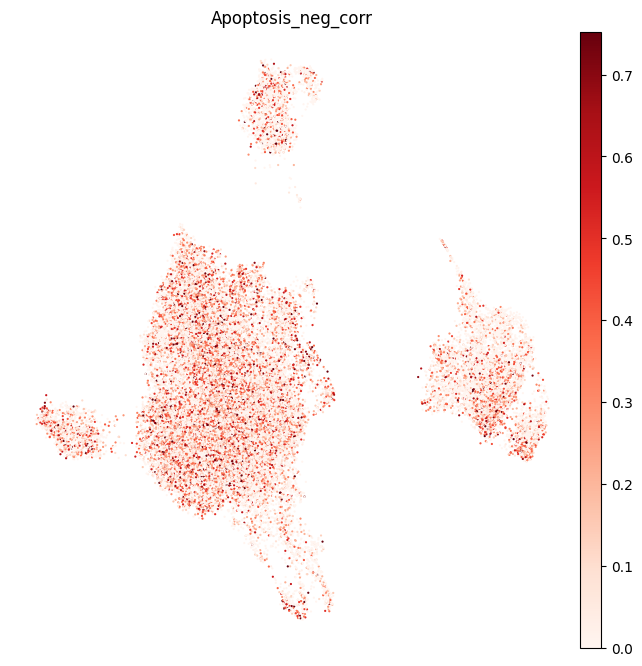

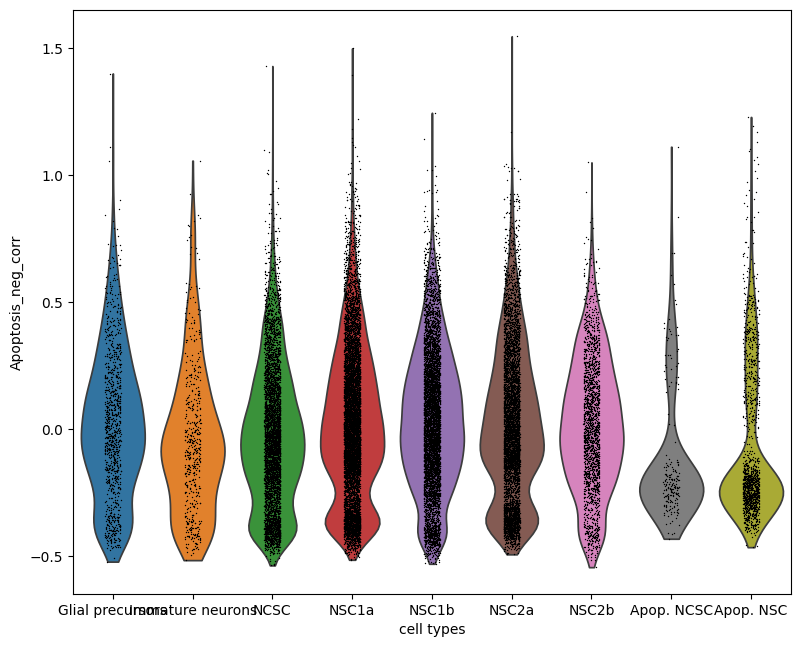

computing score 'Necroptosis_pos_corr'
    finished: added
    'Necroptosis_pos_corr', score of gene set (adata.obs).
    100 total control genes are used. (0:00:01)


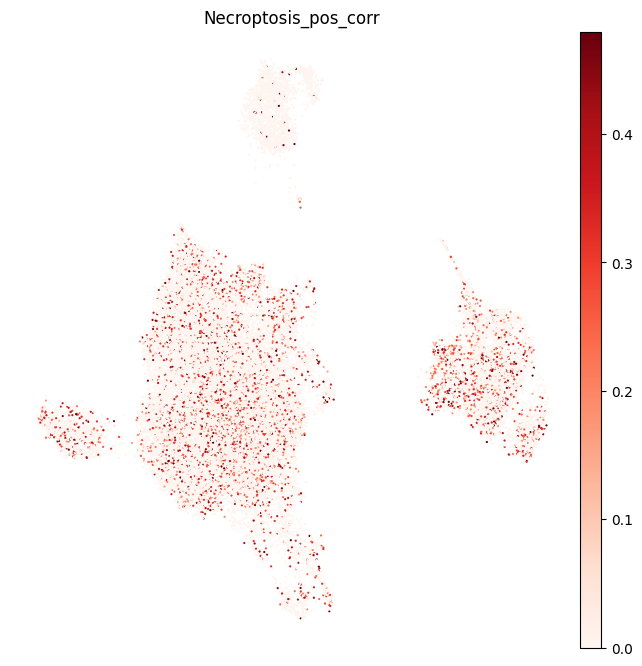

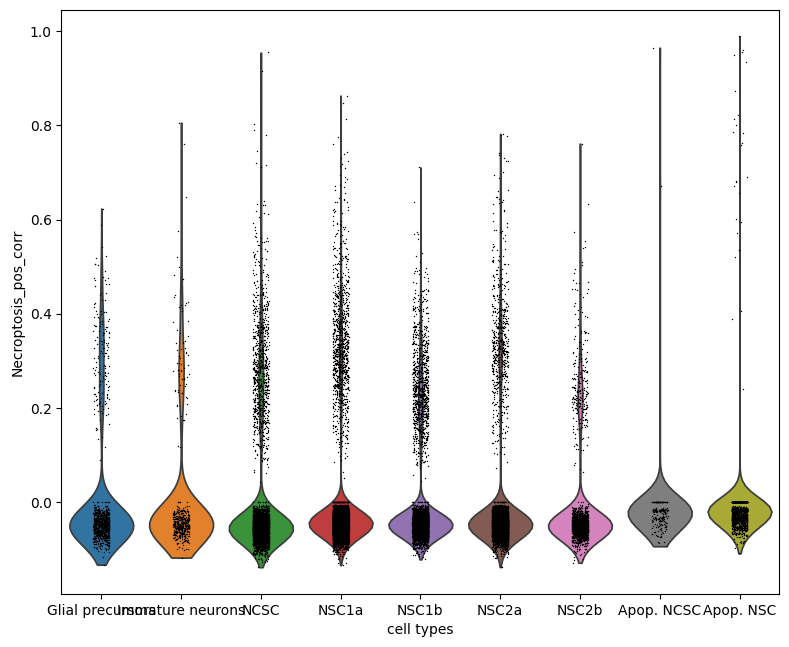

computing score 'Autophagy_pos_corr'
    finished: added
    'Autophagy_pos_corr', score of gene set (adata.obs).
    100 total control genes are used. (0:00:01)


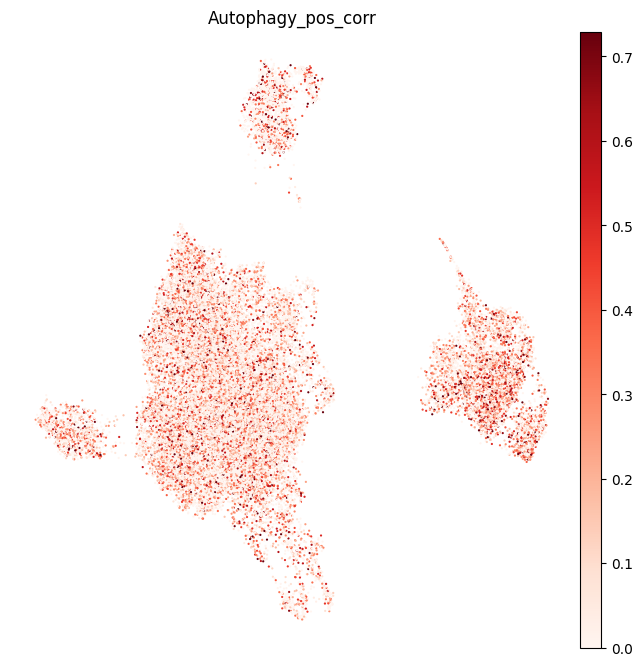

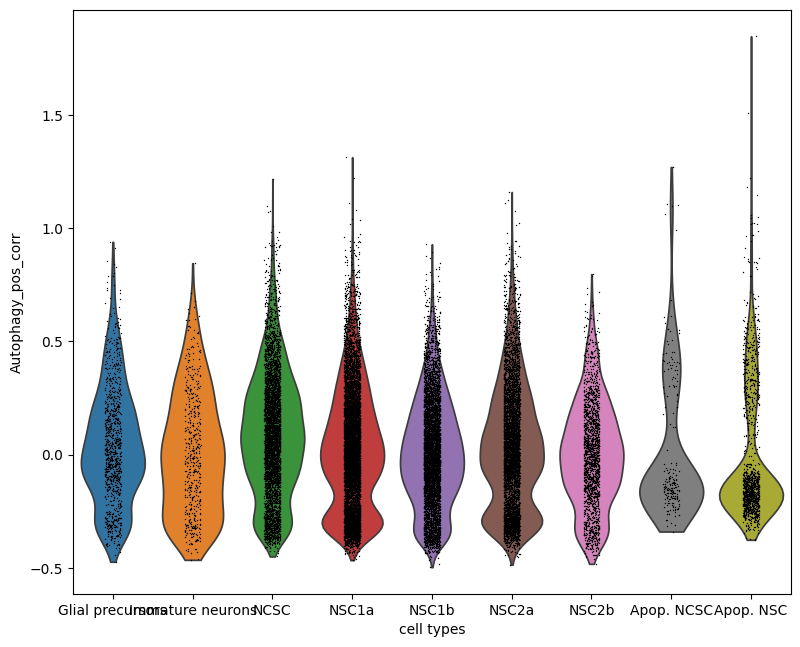

computing score 'Pathanatos_pos_corr'
    finished: added
    'Pathanatos_pos_corr', score of gene set (adata.obs).
    100 total control genes are used. (0:00:01)


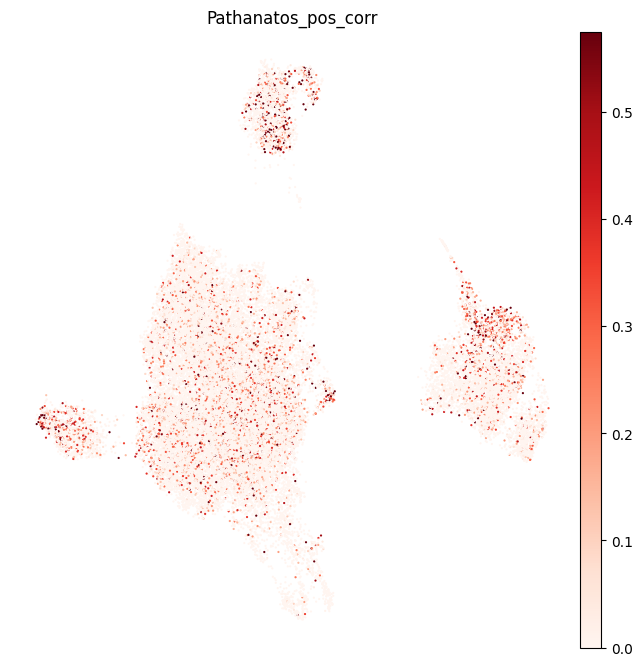

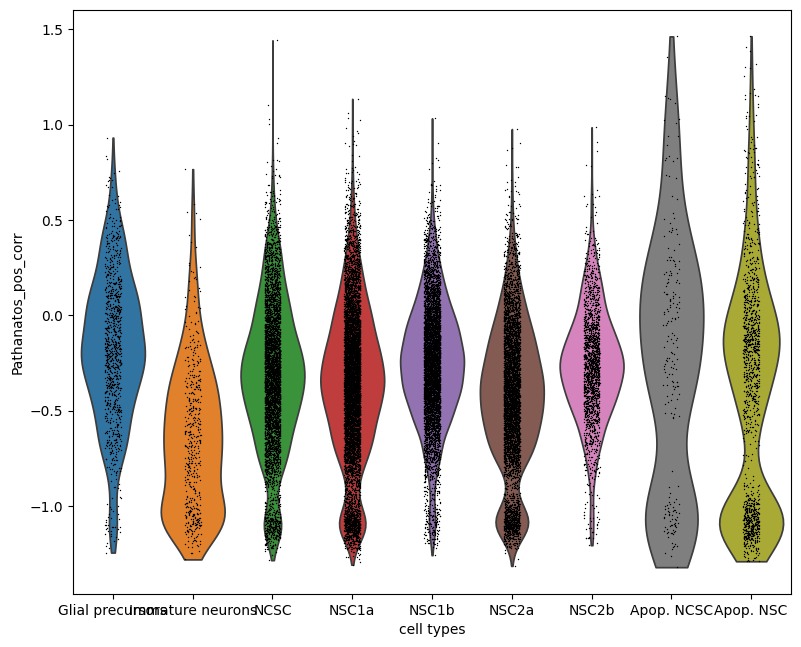

In [30]:
for cd_type in cell_death_markers:
    if len(set(cell_death_markers[cd_type]).intersection(set(adata.var_names))) < 2:
        print(f'{cd_type} score cannot be calculated as there are insufficient markers in the dataset')
    else:
        sc.tl.score_genes(adata, cell_death_markers[cd_type], score_name=cd_type+'_corr', use_raw=True)
        
        sc.pl.umap(adata, color=cd_type+'_corr', size=10, vmin=0, vmax="p99", sort_order=False, frameon=False, cmap="Reds")
        sc.pl.violin(adata, cd_type+'_corr', groupby='cell_types')

# Summary plots

In [28]:
adata.uns['neighbors'] = adata.uns['neighbors_CC']
adata.obsp['distances'] = adata.obsp['distances_CC']
adata.obsp['connectivities'] = adata.obsp['connectivities_CC']
adata.obsm['X_umap'] = adata.obsm['X_umap_CC']

In [29]:
adata.obs['Donor'] = adata.obs['Donor'].cat.reorder_categories(['UKERi1JF-R1-018', 'UKERiG3G-R1-039', 'UKERi1E4-R1-003', 'UKERiO3H-R1-005', 
                                                  'UKERi82A-R1-002', 'UKERiJ2C-R1-015', 'UKERiM89-R1-005', 'UKERiC99-R1-007', 
                                                  'UKERiR66-R1-007', 'UKERiAY6-R1-003', 'UKERiPX7-R1-001', 'UKERi88H-R1-002'])

In [30]:
adata.obs['cell_types'].cat.categories

Index(['Glial precursors', 'Immature neurons', 'NCSC', 'NSC1a', 'NSC1b',
       'NSC2a', 'NSC2b', 'Apop. NCSC', 'Apop. NSC'],
      dtype='object')

In [31]:
col6 = [
'#a6cee3',#'Glial precursors'
'#1f78b4',#'Immature neurons'
'#b2df8a',#'NCSC'
'#33a02c', #NSC1a
'#cab2d6', #NSC1b
'#e31a1c', #NSC2a
'#fdbf6f', #NSC2b
'#6a3d9a', #'Apop. NCSC'
'#ff7f00',#'Apop. cells'
'#cab2d6'
]

In [32]:
adata.uns['cell_types_colors'] = col6

In [5]:
sc.set_figure_params(scanpy=True, dpi_save=300, figsize=(8,8), vector_friendly=True, format='svg',  transparent=True)

In [ ]:
sc.pl.umap(adata, color='cell_types', size=30, title="", frameon=False, save = '_CC_clustering.svg')

In [7]:
parameter_visualization = ['cell_types', 'lane', 'Donor',  
                           'total_counts', 'pct_counts_mt', 'pct_counts_ribo',
                           'phase', 'age', 'gender', 
                           'condition', 'years_of_illness', 'deltaHY', 
                           'deltaUPDRS', 'deltaADL', 'deltaDOPA']



In [ ]:
sc.pl.umap(adata, size=30, color=parameter_visualization, ncols=3, use_raw=True, sort_order=False, frameon=False, cmap="Reds", save='_CC_summary_plots.svg')

In [ ]:
sc.pl.umap(adata, size=30, color=parameter_visualization, ncols=3, use_raw=True, sort_order=False, frameon=False, save='_CC_summary_plots_othercolors.svg')

In [ ]:
alpha=0.5

sc.pl.umap(adata, color='cell_types', size=30, save='_CC_cell_types.svg', title="", frameon=False)
sc.pl.umap(adata, color='Donor', size=30, save='_CC_Donor.svg', title="", frameon=False, alpha=alpha)
sc.pl.umap(adata, color='condition', size=30, save='_CC_condition.svg', title="", frameon=False, alpha=alpha)
sc.pl.umap(adata, color='phase', size=30, save='_CC_phase.svg', title="", frameon=False, alpha=alpha)
sc.pl.umap(adata, color='age', size=30, save='_CC_age.svg', title="", frameon=False, alpha=alpha)
sc.pl.umap(adata, color='gender', size=30, save='_CC_gender.svg', title="", frameon=False, alpha=alpha)
sc.pl.umap(adata, color='years_of_illness', size=30, save='_CC_years_of_illness.svg', title="", frameon=False)
sc.pl.umap(adata, color='deltaHY', size=30, save='_CC_deltaHY.svg', title="", frameon=False)
sc.pl.umap(adata, color='deltaUPDRS', size=30, save='_CC_deltaUPDRS.svg', title="", frameon=False)
sc.pl.umap(adata, color='deltaADL', size=30, save='_CC_deltaADL.svg', title="", frameon=False)
sc.pl.umap(adata, color='deltaDOPA', size=30, save='_CC_deltaDOPA.svg', title="", frameon=False)
sc.pl.umap(adata, color='total_counts', size=30, save='_CC_total_counts.svg', title="", frameon=False)
sc.pl.umap(adata, color='pct_counts_mt', size=30, save='_CC_pct_counts_mt.svg', title="", frameon=False)
sc.pl.umap(adata, color='pct_counts_ribo', size=30, save='_CC_pct_counts_ribo.svg', title="", frameon=False)


# Marker plots

In [11]:
genes =['SOX2', 'FABP7', 'DAAM1', 'PTCH1',
        'SOX2', 'SHH','FOXA2','HES1',
        'SOX10','S100B', 'DCX','MAP2',
        'BCL2','BAX','LUM','LGALS1',
        'CENPF','AURKB','CDC20']

In [40]:
# Abbreviate the cell annotations for plots
adata.obs['cell_types_abbrev'] = ['Glial prec.' if ct.startswith('Glial') else 'Imm. Neurons' if ct.startswith('Immature') else ct for ct in adata.obs['cell_types']]
adata.obs['cell_types_abbrev'] = adata.obs['cell_types_abbrev'].astype('category')

In [41]:
adata.obs['cell_types_abbrev'].cat.categories

Index(['Apop. NCSC', 'Apop. NSC', 'Glial prec.', 'Imm. Neurons', 'NCSC',
       'NSC1a', 'NSC1b', 'NSC2a', 'NSC2b'],
      dtype='object')

In [42]:
col6 = ['#6a3d9a', #'Apop. NCSC'
'#ff7f00',#'Apop. cells'
'#a6cee3',#'Glial precursors'
'#1f78b4',#'Immature neurons'
'#b2df8a',#'NCSC'
'#33a02c', #NSC1a
'#cab2d6', #NSC1b
'#e31a1c', #NSC2a
'#fdbf6f', #NSC2b
'#cab2d6'
]

adata.uns['cell_types_abbrev_colors'] = col6


In [ ]:
sc.pl.umap(adata, size=30, color=genes+["cell_types_abbrev"], ncols=4, title=genes+[''], use_raw=False, vmin=0, vmax="p99", sort_order=False, frameon=False, cmap="Reds", save='_CC_marker_genes.svg')

In [ ]:
sc.pl.dotplot(adata, genes , groupby = 'cell_types', cmap= 'Reds', 
              mean_only_expressed = True, save = 'dotplot_markers.svg')

# Summary plots noCC

In [13]:
adata.uns['neighbors'] = adata.uns['neighbors_noCC']
adata.obsp['distances'] = adata.obsp['distances_noCC']
adata.obsp['connectivities'] = adata.obsp['connectivities_noCC']
adata.obsm['X_umap'] = adata.obsm['X_umap_noCC']

In [ ]:
sc.pl.umap(adata, color='cell_types', size=30, title="", frameon=False, save = '_noCC_clustering.svg')

In [ ]:
sc.pl.umap(adata, size=30, color=parameter_visualization, ncols=3, use_raw=True, sort_order=False, frameon=False, cmap="Reds", save='_noCC_summary_plots.svg')

In [ ]:
sc.pl.umap(adata, size=30, color=parameter_visualization, ncols=3, use_raw=True, sort_order=False, frameon=False, save='_noCC_summary_plots_othercolors.svg')

In [ ]:
alpha=0.5

sc.pl.umap(adata, color='cell_types', size=30, save='_noCC_cell_types.svg', title="", frameon=False)
sc.pl.umap(adata, color='Donor', size=30, save='_noCC_Donor.svg', title="", frameon=False, alpha=alpha)
sc.pl.umap(adata, color='condition', size=30, save='_noCC_condition.svg', title="", frameon=False, alpha=alpha)
sc.pl.umap(adata, color='phase', size=30, save='_noCC_phase.svg', title="", frameon=False, alpha=alpha)
sc.pl.umap(adata, color='age', size=30, save='_noCC_age.svg', title="", frameon=False, alpha=alpha)
sc.pl.umap(adata, color='gender', size=30, save='_noCC_gender.svg', title="", frameon=False, alpha=alpha)
sc.pl.umap(adata, color='years_of_illness', size=30, save='_noCC_years_of_illness.svg', title="", frameon=False)
sc.pl.umap(adata, color='deltaHY', size=30, save='_noCC_deltaHY.svg', title="", frameon=False)
sc.pl.umap(adata, color='deltaUPDRS', size=30, save='_noCC_deltaUPDRS.svg', title="", frameon=False)
sc.pl.umap(adata, color='deltaADL', size=30, save='_noCC_deltaADL.svg', title="", frameon=False)
sc.pl.umap(adata, color='deltaDOPA', size=30, save='_noCC_deltaDOPA.svg', title="", frameon=False)
sc.pl.umap(adata, color='total_counts', size=30, save='_noCC_total_counts.svg', title="", frameon=False)
sc.pl.umap(adata, color='pct_counts_mt', size=30, save='_noCC_pct_counts_mt.svg', title="", frameon=False)
sc.pl.umap(adata, color='pct_counts_ribo', size=30, save='_noCC_pct_counts_ribo.svg', title="", frameon=False)


# Marker plots noCC

In [ ]:
sc.pl.umap(adata, size=30, color=genes+["cell_types_abbrev"], ncols=4, title=genes+[''], use_raw=False, vmin=0, vmax="p99", sort_order=False, frameon=False, cmap="Reds", save='_noCC_marker_genes.svg')

# Write data to file

In [ ]:
adata.uns['neighbors'] = adata.uns['neighbors_CC']
adata.obsp['distances'] = adata.obsp['distances_CC']
adata.obsp['connectivities'] = adata.obsp['connectivities_CC']
adata.obsm['X_umap'] = adata.obsm['X_umap_CC']

In [ ]:
# Remove rank_genes_groups output, which is tough to save to file
ad_uns_keys = list(adata.uns.keys())

for i in ad_uns_keys:
    if i.startswith('rank_'):
        print(f'removing {i}')
        del adata.uns[i]

In [ ]:
# Remove rank_genes_groups output, which is tough to save to file
ad_uns_keys = list(adata.uns.keys())

for i in ad_uns_keys:
    if i.startswith('leiden_'):
        print(f'removing {i}')
        del adata.uns[i]

In [ ]:
# Remove rank_genes_groups output, which is tough to save to file
ad_uns_keys = list(adata.uns.keys())

for i in ad_uns_keys:
    if i.startswith('dendrogram_leiden'):
        print(f'removing {i}')
        del adata.uns[i]

In [ ]:
# Remove unnecessary obs
ad_obs_keys = list(adata.obs.keys())

for i in ad_obs_keys:
    if i.startswith('leiden_'):
        print(f'removing {i}')
        del adata.obs[i]

In [ ]:
adata.write(adata_output)